In [1]:
import ROOT
import seaborn as sns
import pandas as pd
import numpy as np

Welcome to JupyROOT 6.30/08


In [2]:
# folder = "/lustre/land/ilihtar/neuland/sim_August24"
# digi_file_name = "digi1n_phasespace_25MeV_thresh0.root"
# simu_file_name = "sim1n_phasespace_25MeV.root"
folder = "/lustre/r3b/ywang/test/first_hit"
simu_file_name = "simu.root"
mock_tamex_file_name = "digi_mock_paddle_tamex_channel.root"
neuland_tamex_file_name = "digi_neuland_paddle_tamex_channel.root"
neuland_mock_file_name = "digi_neuland_paddle_mock_channel.root"
neuland_tacquila_file_name = "digi_neuland_paddle_tacquila_channel.root"
mock_tacquila_file_name = "digi_mock_paddle_tacquila_channel.root"
mock_mock_file_name = "digi_mock_paddle_mock_channel.root"

point_branches = ["NeulandPoints.fTime", "NeulandPoints.fDetectorID"]
hit_branches = ["NeulandHits.fT", "NeulandHits.fPaddle"]


In [3]:
def create_data_frame(folder, filename, branches, paddle_label = None, channel_label = None, simu_dataframe = pd.DataFrame()):
    root_file = ROOT.TFile(f"{folder}/{filename}")
    data_arrays = ROOT.RDataFrame("evt", root_file).AsNumpy(branches)
    
    event_size = len(data_arrays[branches[0]])
    times = np.zeros(event_size, dtype = 'float32')
    plane_ids = np.zeros(event_size, dtype = 'int') # starts from 0
    times[:] = np.nan
    plane_ids[:] = -1
    
    event_index = 0
    for fTs, paddleNums in zip(data_arrays[branches[0]], data_arrays[branches[1]]):
        if len(fTs) != 0:
            fT_min, paddle_num = min(zip(fTs, paddleNums), key = lambda x: x[0])
            times[event_index] = fT_min
            plane_ids[event_index] = (paddle_num - 1) // 50
        event_index += 1
    data_frame = pd.DataFrame({"plane_id": plane_ids, "times": times}).dropna()
    if not simu_dataframe.empty:
        new_simu = simu_dataframe.copy()
        new_simu["level"] = "hits"
        data_frame["level"] = "points"
        data_frame = pd.concat([data_frame, new_simu])
    if paddle_label != None:
        data_frame["paddle"] = paddle_label
    if channel_label != None:
        data_frame["channel"] = channel_label
    return data_frame

In [4]:
simu = create_data_frame(folder, simu_file_name, point_branches)
neuland_tamex = create_data_frame(folder, neuland_tamex_file_name, hit_branches, "neuland", "tamex", simu)
neuland_mock = create_data_frame(folder, neuland_mock_file_name, hit_branches, "neuland", "mock", simu)
neuland_tacquila = create_data_frame(folder, neuland_tacquila_file_name, hit_branches, "neuland", "tacquila", simu)
mock_tamex = create_data_frame(folder, mock_tamex_file_name, hit_branches, "mock", "tamex", simu)
mock_mock = create_data_frame(folder, mock_mock_file_name, hit_branches, "mock", "mock", simu)
mock_tacquila = create_data_frame(folder, mock_tacquila_file_name, hit_branches, "mock", "tacquila", simu)

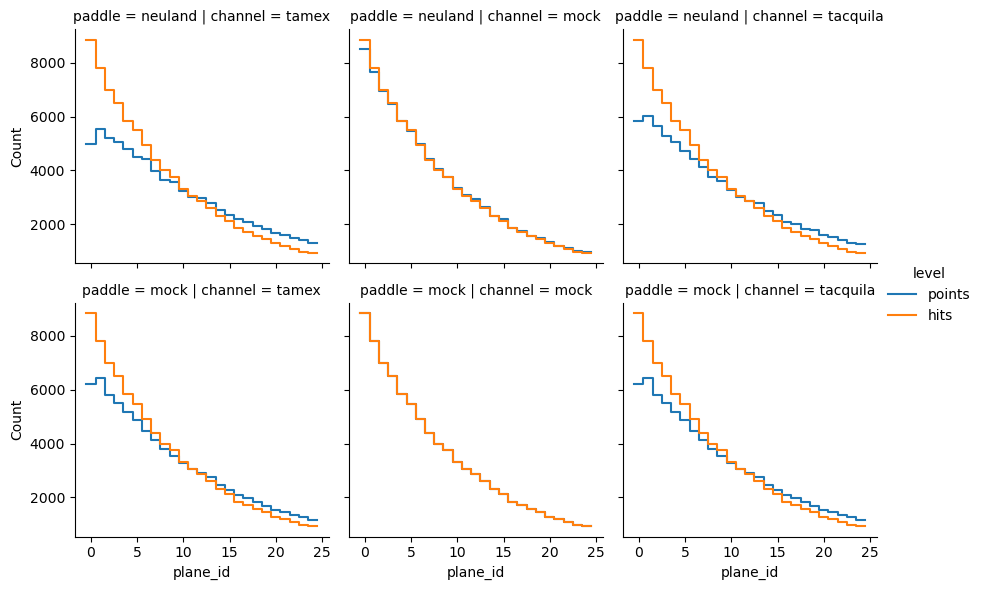

In [6]:

plane_id_compare = pd.concat([neuland_tamex, neuland_mock, neuland_tacquila, mock_tamex, mock_mock, mock_tacquila])

graphs = sns.FacetGrid(plane_id_compare, col = "channel", row = "paddle", hue = "level")
graphs.map_dataframe(sns.histplot, x = "plane_id", binwidth = 1, binrange = [-0.5, 24.5], element="step", fill = False)
graphs.add_legend()